# Zonnepanelen

Geschreven door Ivo Peters (ivo.r.peters at gmail.com)
24 december 2017

Veel informatie en methodes om zonnestanden uit te rekenen heb ik van deze website:
http://www.pveducation.org/


In [63]:
# importeer numerieke bibliotheek
import numpy as np
# importeer grafische bibliotheek
import matplotlib.pyplot as plt

## Invoeren van gegevens

### Gegevens over de zonnepanelen en plaatsing
De in te voeren gegevens zijn:
 - Efficientie ("eta"). Voobeeld: eta = 0.2 betekent 20% efficientie
 - Oppervlak per paneel in vierkante meters
 - Aantal panelen
 - Vertikale hoek in graden ("beta_graden"), beta_graden = 0 betekent dat de panelen plat op de grond liggen, beta_graden = 90 betekent  dat de panelen vertikaal staan
 - Horizontale hoek in graden ("Psi_graden"), voorbeelden:
     Psi_graden = 90 -> panelen zijn naar het Oosten gericht
     Psi_graden = 180 -> panelen zijn naar het Zuiden gericht
     Psi_graden = 270 -> panelen zijn naar het Westen gericht

In [64]:
eta = 0.18 # efficientie
oppervlakte_per_paneel = 1.7
aantal_panelen = 12
beta_graden = 45.0
Psi_graden = 180.0

### Gegevens over de locatie
De in te voeren gegevens zijn:
 - Hoogtegraad (Doetinchem = 51.96)
 - Breedtegraad (Doetinchem = 6.29)
Tip: om de hoogte- en breedtegraad van een willekeurige plaats te vinden, klik met de rechtemuisknop op een plek in google maps en klik dan op "What's here" of de Nederlandse vertaling daarvan.

In [65]:
breedtegraad = 51.9
lengtegraad = 6.29

### Dagnummer om uit te rekenen
Dagnummers ("dag") lopen van dag = 1 op 1 januari tot dag = 365 op 31 december.

Een paar referentiepunten:
 - 1:   1 januari
 - 32:  1 februari
 - 60:  1 maart
 - 91:  1 april
 - 121: 1 mei
 - 152: 1 juni
 - 172: 21 juni (langste dag)
 - 182: 1 juli
 - 213: 1 augustus
 - 244: 1 september
 - 274: 1 oktober
 - 305: 1 november
 - 335: 1 december
 - 355: 21 december (kortste dag)

In [66]:
dag = 311

## Berekeningen
Vanaf hier alleen nog maar berekeningen, hieronder hoeven dus geen gegevens meer veranderd te worden.

### Omrekenen naar radialen
Alle ingegeven hoeken in graden omzetten naar hoeken in radialen:

In [67]:
beta = beta_graden / 180.0 * np.pi
Psi = Psi_graden / 180.0 * np.pi
phi = breedtegraad / 180.0 * np.pi

### Declinatiehoek
De hoek van de aarde ten opzichte van de zon (de oorzaak van de seizoenen op aarde) wisselt tussen de -23.45 tot +23.45 graden.

In [68]:
delta_deg = -23.45 * np.cos(2.0*np.pi/365.0*(dag+10.0))
# omrekenen naar radialen
delta = delta_deg / 180.0 * np.pi

### Array voor de locale zonnetijd
Locale zonnetijd ("LST", voor local solar time) is zo gedefinieerd dat de zon altijd om 12:00 uur op het hoogste punt staat. Tijden zijn in uren opgegeven. Bijvoorbeeld, LST = 6 betekent 6 uur 's ochtends, en LST = 13.5 betekent half twee 's middags in zonnetijd.

In [69]:
LST = np.linspace(0, 24, 100)

### Uurhoek (hourly angle, HRA)
Voor het gemak in de berekeningen, de hoek die afhankelijk is van het uur van de dag

In [70]:
HRA = (15.0*(LST-12.0)) / 180.0 * np.pi

### Hoek van de zon 1: alpha
Dit is de hoek van de zon boven de horizon. Dit is afhankelijk van de declinatiehoek, de breedtegraad, en het tijdstip (via de uurhoek HRA):

In [71]:
alpha = np.arcsin(np.sin(delta)*np.sin(phi) + np.cos(delta)*np.cos(phi)*np.cos(HRA))
# zodra de zon onder de horizon is zetten we de hoek op nul:
alpha[alpha<0] = 0
# omrekenen naar graden:
alpha_deg = alpha/np.pi*180.0

### Hoek van de zon 2: theta
Dit is de windrichting van waaruit de zon schijnt. Gedefinieerd als:
90 graden is Oost, 180 graden is Zuid, 270 graden is West. Deze hoek is ook afhankelijk van de declinatiehoek, de breedtegraad, en het tijdstip (via de uurhoek HRA):

In [72]:
theta = np.arccos((np.sin(delta)*np.cos(phi) - np.cos(delta)*np.sin(phi)*np.cos(HRA))/np.cos(alpha))
# correctie voor namiddagzon
theta[LST>12] = 2*np.pi-theta[LST>12]
# omrekenen naar graden
theta_deg = theta/np.pi*180.0

### Absorptie door de atmosfeer
Hoe lager de zon staat, hoe meer atmosfeer er tussen de zon en het aardoppervlak zit. Dit vermindert de intensiteit van de zon. We rekenen eerst de hoeveelheid atmosfeer uit, en passen vervolgens een empirische formule toe om de intensiteit van de zon uit te rekenen:

In [73]:
# Genormalizeerde hoeveelheid atmosfeer
AM = 1.0 / np.cos(np.pi/2.0-alpha)
# Intensiteit van direct zonlicht (in W/m^2)
I_D = 1353*0.7**(AM**0.678)

### Vermogen van het zonnepaneel
We rekenen het vermogen dat het zonnepaneel levert uit in verschillende stappen.
#### 1. Intensiteit aan zonlicht dat op het paneel valt

In [74]:
I_paneel = I_D * (np.cos(alpha)*np.sin(beta)*np.cos(Psi-theta) + np.sin(alpha)*np.cos(beta))
# Correctie voor zon die het paneel niet meet bereikt:
I_paneel[I_paneel<0] = 0

#### 2. Vermogen dat de panelen leveren
Uitgerekend in Watts, afhankelijk van het totale oppervlak aan panelen en de efficientie (eta) van de panelen.

In [75]:
P = aantal_panelen * oppervlakte_per_paneel * eta * I_paneel

#### 3. Het vermogen tijdens het verloop van de dag in een grafiek

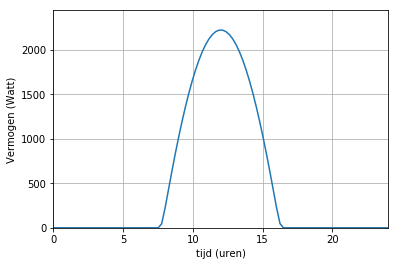

In [76]:
plt.plot(LST, P)
plt.xlim(0, 24)
plt.ylim(0, 1.1*np.max(P))
plt.xlabel('tijd (uren)')
plt.ylabel('Vermogen (Watt)')
plt.grid()

#### 4. Dagopbrengst in kWh
De bovenstaande grafiek kunnen we numeriek integreren om de opbrengst van de dag uit te rekenen.

In [77]:
# De integratiestap (tijdstap in uren):
dLT = (LST[1]-LST[0])
# Totale energie:
E = np.sum(P*dLT/1000.0)
print("Geproduceerde energie: %0.2f kWh" % E)

Geproduceerde energie: 12.26 kWh


#### 5. Dagopbrengst inclusief diffuus licht
Dit is een ruwe schatting, dat we 10% extra opbrengts hebben door licht dat niet direct op de panelen valt, maar via verstrooing in de atmosfeer

In [78]:
E_G = 1.1 * E
print("Totale geproduceerde energie: %0.2f kWh" % E_G)

Totale geproduceerde energie: 13.48 kWh
